In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[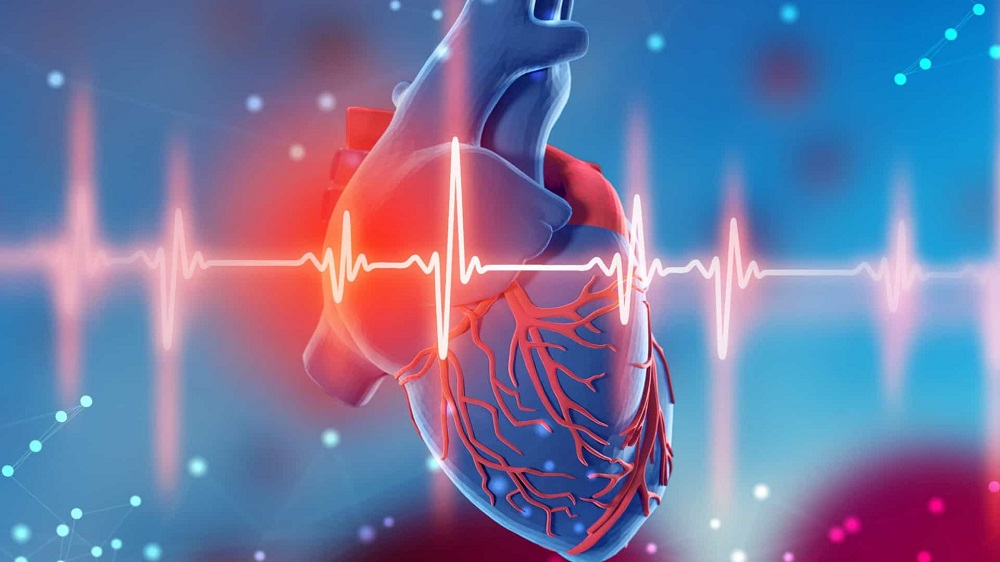]

**Cardiovascular diseases are a set of problems that affect the heart and blood vessels, and that arise with age, usually related to unhealthy lifestyle habits, such as high-fat diet and lack of physical activity, for example. However, cardiovascular diseases can also be diagnosed at birth, as is the case with congenital heart diseases.**
**It is important that cardiovascular diseases are properly treated because, in addition to causing uncomfortable symptoms, such as shortness of breath, chest pain or swelling in the body, they are also the main cause of death in the world.**

**Let's check it out.**

**First, let's import our main libraries.**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve,plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

**Here we have a function that will help us to control the dimensions of our graphics. **

In [ ]:
def resizeplot(l,a,d):
    plt.figure(figsize=(l,a),dpi=d)

**Load the dataset.**

In [ ]:
df = pd.read_csv('/kaggle/input/heart-attack-prediction/data.csv')

In [ ]:
df.head()

**Hummm, let's keep digging.**

In [ ]:
df.isnull().sum()

In [ ]:
df.info()

**Apparently we don't have missing data but we have "?", Let's deal with them.**

In [ ]:
df = df.replace({'?':np.nan})

In [ ]:
df = df.rename(columns={'num       ':'num'})

**What we did above was to transform the character "?" and turn it into Nan, and in the column 'one' that is extremely important for our future analysis we remove unnecessary spaces.**

In [ ]:
df.head()

**We will fill these missing data with the knn algorithm.**

In [ ]:
df.drop('ca',inplace=True,axis=1)

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
inputer_int = KNNImputer(missing_values=np.nan)

In [ ]:
df.iloc[:,3:9] = inputer_int.fit_transform(df.iloc[:,3:9])

In [ ]:
df.iloc[:,10:12] = inputer_int.fit_transform(df.iloc[:,10:12])

In [ ]:
df.iloc[:,10:12] = round(df.iloc[:,10:12])

In [ ]:
df.head()

**Right, first we remove the "ca" feature because its technically irrelevant to our data, **
**And then fill the missing data with knn inputer predictions**

**Ok, let's start to analisys seen some graphs**

**Wide variation of ages but with a dense number of people over 45 in this data.**

In [ ]:
resizeplot(10,6,100)
sns.histplot(df['age'],kde=True,bins=50)

**In this boxplot, we observed a greater number of male people, however with an average age of approximately.
This may not seem like it, but it is fundamental information for our future observations.**

In [ ]:
resizeplot(10,6,80)
sns.boxplot(x='sex',y='age',data=df)

**Here is a plot that always brings us good observations, a positive and considerable correlation between individuals who had induced angina (exang) and ST depression (oldpeak) which makes sense since ST depression is basically a stress test where observes in its recovery phase.**

In [ ]:
correl = df.corr()

In [ ]:
resizeplot(12,6,80)
sns.heatmap(correl, annot=True)

**Before looking at the graph below, let's clarify a few points: blood pressure is a measure of the strength of the blood flowing against the walls of the arteries, the heart rate, also called the pulse, is the number of times the heart beats every minute . Low blood pressure and low heart rate do not always indicate problems to the individual; Between these two, high blood pressure is the main factor of stroke and heart attack.
Considering the blue peaks, these, from a superficial analysis, should pay attention to your health.**

In [ ]:
df[['age','trestbps','thalach']].iplot()

**Here we have a relationship between age and resting blood pressure. Note that regardless of age, blood pressures vary widely.**

In [ ]:
resizeplot(17,6,80)
sns.barplot(y='age',x='trestbps',data=df)

**As much as people have high levels of high cholesterol, heart rate does not vary as much as we previously considered.**

In [ ]:
df[['chol','thalach']].iplot(kind='spread')
import numpy as np

**Below, we can observe the relationship between resting blood pressure, maximum heart rate, age, cholesterol and the risk of heart disease.**

In [ ]:
sns.pairplot(df[['age','trestbps','chol','thalach','num']],hue='num')

**Another interesting plot, regardless of the individual's gender, cholesterol levels are very approximate.**

In [ ]:
resizeplot(10,6,60)
sns.boxplot(x='sex',y='chol',data=df)

**A comparison between the sex of individuals with regard to fasting blood sugar. We also observed a high standard deviation compared to that of men with a very high standard deviation among women.**

In [ ]:
resizeplot(10,6,60)
sns.barplot(x='sex',y='fbs',data=df)

**Below, people with exercise-induced angina according to cholesterol levels. The slight majority had effects of angina.**

In [ ]:
resizeplot(10,6,60)
sns.barplot(x='exang',y='chol',data=df)

**A visualization grouped by induced angina shows a high comparison with high cholesterol and other features and a high risk of heart attack.**

**Select one of the features to interact with the chart.**

In [ ]:
df.groupby('exang').mean().iplot(kind='bar')

**Let's look at this data from another angle. Perhaps this is the most decisive. - why didn't I start the analysis with him?
Here we have grouped on a scale of 1 to 4 for angina (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic) people related to number 4 did not show signs of angina, however, high cholesterol, high blood pressure at rest, relatively normal heart rate compared to others, and increased risk of heart attack. What does all this tell us?
Atherosclerosis, for example, is a progressive disease and can affect all arteries in the body.
However, their symptoms are often “ignored” the reason for this is the lack of knowledge and dissemination.
Many people have no complaints at first, however, after being examined and a change in the arteries of the leg and / or arm is found, they confirm that they had symptoms.**

In [ ]:
df.groupby('cp').mean().iplot(kind='bar')

**Let's go to the models, however, what I could do to improve the predictions would be to separate them into groups according to the graph above because we would analyze the situations on a case by case basis, but as this dataset is small, this would compromise the result of our models, so we will do with the entire dataset.**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df.drop('num',axis=1)
y = df['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [ ]:
scaler = StandardScaler()

In [ ]:
scaled_X_train = scaler.fit_transform(X_train)

In [ ]:
scaled_X_test = scaler.transform(X_test)

# **Logistic Regression Model**

In [ ]:
model_log = LogisticRegressionCV()

In [ ]:
model_log.fit(scaled_X_train,y_train)

In [ ]:
model_log.C_

In [ ]:
model_log.coef_

In [ ]:
coefi = pd.Series(index=X.columns,data=model_log.coef_[0])

In [ ]:
coefi

In [ ]:
resizeplot(10,6,60)
coefi = coefi.sort_values()
sns.barplot(x=coefi.index,y=coefi.values)

In [ ]:
y_pred = model_log.predict(scaled_X_test)

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
plot_confusion_matrix(model_log,scaled_X_test,y_test)

In [ ]:
print(classification_report(y_test,y_pred))

**Lets create the recall curves precisions.**

In [ ]:
plot_precision_recall_curve(model_log,scaled_X_test,y_test)

In [ ]:
plot_roc_curve(model_log,scaled_X_test,y_test)

**Lets check if our model is predicting the right(or possibles) values from a random patient.**

In [ ]:
patient = [[55.,1.,0.,122.,286.,0.,0.,115.,1.,3.2,1.,2.]]

In [ ]:
model_log.predict(patient)

In [ ]:
model_log.predict_proba(patient)

# **Kneighbors Classifier**

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
operators = [('scaler',scaler),('knn',knn)]

In [ ]:
pipe = Pipeline(operators)

In [ ]:
k_values = list(range(1,30))
param_grid = {'knn__n_neighbors':k_values}
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')

In [ ]:
full_cv_classifier.fit(X_train,y_train)

In [ ]:
y_pred_knn = full_cv_classifier.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred_knn))

# Decision Tree Classifier

In [ ]:
model_dt = DecisionTreeClassifier()

In [ ]:
model_dt.fit(X_train,y_train)

In [ ]:
pred_dt = model_dt.predict(X_test)

In [ ]:
print(classification_report(y_test,pred_dt))

In [ ]:
plot_confusion_matrix(model_dt,X_test,y_test)

# SVC

In [ ]:
svc = SVC(C=0.1,class_weight='balanced')

In [ ]:
param_grid_svc = {'C':[0.001,0.01,0.1,0.5,1]}
grid_svc = GridSearchCV(svc,param_grid_svc)

In [ ]:
grid_svc.fit(scaled_X_train,y_train)

In [ ]:
grid_svc.best_params_

In [ ]:
grid_pred_svc = grid_svc.predict(scaled_X_test)

In [ ]:
print(classification_report(y_test,grid_pred_svc))

In [ ]:
plot_confusion_matrix(grid_svc,scaled_X_test,y_test)

**As we can see, Logistic Regression was our winning algorithm, followed by SVC and Decision Tree and the worst result was with KNN. This classifying score pointed out the risk of having a heart attack based on the information passed and observed by the graphs. Our Knn inputer algorithm was decisive in filling in the missing data since it is not very safe to always fill in this data with the averages of the information.**

***Well guys, that's it. I hope you enjoyed this notebook, study, be well and if you liked it please give an UPVOTE.***

**See you!**